In [1]:
import math
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import tqdm
import torchvision.models as models
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm


In [2]:
# 假设 get_doubly_random_matrix 和 get_strongly_connected_directed_row_column_stochastic_matrix 
# 返回形状为 (agents_num, agents_num) 的 torch.Tensor
from utils.doubly_random_matrix import get_doubly_random_matrix, get_strongly_connected_directed_row_column_stochastic_matrix
from utils.timestamp import get_strftime
from utils.make_dirs import make_dir
from utils.plot_fig import plot_lr_all_info


In [32]:

# 设置字体优先级：中文用宋体，英文用 Times New Roman

plt.rcParams['font.sans-serif'] = ['Times New Roman']  # ✅ 宋体+Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常

# 指定中英文字体路径
chinese_font_path = 'C:/Windows/Fonts/simsun.ttc'  # 替换为你的宋体路径
english_font_path = 'C:/Windows/Fonts/times.ttf'   # 替换为 Times New Roman 路径

chinese_font = fm.FontProperties(fname=chinese_font_path)
english_font = fm.FontProperties(fname=english_font_path)

In [4]:
data_name="cifar10"

In [5]:
root_path=f"./logs/qdadamPS_compare_binary_logistic_regression/{data_name}"
path=os.path.join(root_path,get_strftime())
make_dir(path)

In [6]:
# -------------------------
# 全局超参数（请根据实际需要调整）
agents_num = 5
step_init = 0.1      # 较小的局部学习率
batch_size = 128
beta1 = 0.9
beta2 = 0.999
beta3 = 0.9
G0 = 1e-3              # 示例参数
beta1t_lambda = 0.9    # 示例参数
kt_pow = 1.5           # 量化层数参数（量化等级）
eps = 1e-8

In [7]:
# 设备配置（GPU 优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# -------------------------
# 数据预处理：对于 ResNet 网络，保持图像尺寸，做归一化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# 下载 CIFAR-10 数据集（修改数据存放路径）
train_dataset = torchvision.datasets.CIFAR10(root=r'E:\Data', train=True, transform=transform, download=True)
test_dataset  = torchvision.datasets.CIFAR10(root=r'E:\Data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
# -------------------------
# 获取共识矩阵（用于跨智能体参数同步）
# 这里 net[i,j] 表示第 i 个智能体从第 j 个智能体获得的权重
R, C = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num, show=False)
net = C.T  

In [10]:
def ResNet18CIFAR():
    model = models.resnet18(pretrained=True)
    # 修改第一层卷积，使之适应 32x32 的 CIFAR-10 图像
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # 移除 maxpool 层
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

In [11]:
# -------------------------
# Torch 版本的概率量化函数（向量化实现）
def probabilistic_quantizer(v, kt, use_quantize=True):
    if (not use_quantize) or (kt <= 0):
        return v
    # v: torch.Tensor
    floor_v = torch.floor(v * kt) / kt
    ceil_v  = torch.ceil(v * kt) / kt
    r = torch.rand(v.shape, device=v.device)
    diff = v - floor_v
    threshold = diff * kt
    mask = r < threshold
    q_v = torch.where(mask, floor_v, ceil_v)
    return q_v

In [12]:
# -------------------------
# 自定义 QPSD-ADAM 优化器（包含共识更新，使用量化）
class CustomQPSDADAM:
    def __init__(self, params, agent_id, lr=0.001, beta1=0.9, beta2=0.999, beta3=0.9,
                 G0=1e-3, beta1t_lambda=0.9, kt_pow=1.5, eps=1e-8):
        self.agent_id = agent_id
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.G0 = G0
        self.beta1t_lambda = beta1t_lambda
        self.kt_pow = kt_pow
        self.eps = eps
        self.t = 0
        # 为每个参数存储状态
        self.state = {}
        for p in self.params:
            self.state[p] = {
                'm': torch.zeros_like(p.data),
                'v': torch.zeros_like(p.data),
                'v_bar': torch.zeros_like(p.data),
                'y': torch.ones_like(p.data),
                'x': p.data.clone(),   # 初始 x 取初始参数
                'z': torch.zeros_like(p.data)
            }
    
    def step(self, global_optimizers):
        """
        global_optimizers: 包含所有 agents 的优化器实例列表，用于共识更新。
        要求各个 agent 的优化器中参数顺序一致，即当前 agent 的第 i 个参数对应其他 agent 的第 i 个参数。
        """
        self.t += 1
        for idx, p in enumerate(self.params):
            if p.grad is None:
                continue
            state = self.state[p]
            # 共识更新：聚合各个邻居的状态 x 和 y（量化后）
            x_ = torch.zeros_like(p.data)
            y_ = torch.zeros_like(p.data)
            for jj, opt in enumerate(global_optimizers):
                # 按索引匹配对应参数
                p_jj = opt.params[idx]
                # 量化：kt 随迭代次数自适应取 ceil((t+1)**kt_pow)
                q_x = probabilistic_quantizer(opt.state[p_jj]['x'],
                                              kt=math.ceil((self.t+1)**self.kt_pow),
                                              use_quantize=True)
                # 对 y 这里可以直接使用，不进行量化，也可以加量化（此处保留原样）
                y_jj = opt.state[p_jj]['y']
                x_ = x_ + net[self.agent_id, jj] * q_x
                y_ = y_ + net[self.agent_id, jj] * y_jj
            state['x'] = x_
            state['y'] = y_
            state['z'] = state['x'] / state['y'] 
            # 将当前参数更新为共识变量 z
            p.data.copy_(state['z'])
            # 本地梯度更新（基于 z 进行更新）
            grad = p.grad.data
            state['m'] = self.beta1 * state['m'] + (1 - self.beta1) * grad
            state['v'] = self.beta2 * state['v'] + (1 - self.beta2) * (grad * grad)
            m_hat = state['m'] / (1 - self.beta1 ** self.t)
            v_hat = state['v'] / (1 - self.beta2 ** self.t)
            state['v_bar'] = self.beta3 * state['v_bar'] + (1 - self.beta3) * torch.max(v_hat, state['v_bar'])
            update = (self.lr/math.sqrt(self.t)) * m_hat / (torch.sqrt(v_hat) + self.eps)
            state['x'] = state['x'] - update

# -------------------------

In [13]:
# -------------------------
# Aggregation 类，管理多个智能体及其模型、优化器、数据加载器
class Aggregation:
    def __init__(self, custom_optimizer, agents_num, step_init, **opt_kwargs):
        self.agents_num = agents_num
        self.models_ls = []
        self.optimizers_ls = []
        self.criterions_ls = []
        self.train_loaders_ls = []
        self.avg_model = ResNet18CIFAR().to(device)
        self.avg_criterion=nn.CrossEntropyLoss()
        
        # 将训练集均匀划分给各智能体
        n_total = len(train_dataset)
        split_lengths = [n_total // agents_num] * agents_num
        remainder = n_total - sum(split_lengths)
        for i in range(remainder):
            split_lengths[i] += 1
        train_dataset_ls = random_split(train_dataset, split_lengths)
        
        for i in range(agents_num):
            # 使用小型 ResNet 代替 MLP
            model = ResNet18CIFAR().to(device)
            optimizer = custom_optimizer(model.parameters(), agent_id=i, lr=step_init, **opt_kwargs)
            criterion = nn.CrossEntropyLoss()
            train_loader = DataLoader(train_dataset_ls[i], batch_size=batch_size, shuffle=True)
            
            self.models_ls.append(model)
            self.optimizers_ls.append(optimizer)
            self.criterions_ls.append(criterion)
            self.train_loaders_ls.append(train_loader)
    
    def average_model(self):
        """
        生成一个模型，其参数为各智能体模型参数的平均值，用于评估。
        """
        with torch.no_grad():
            avg_state_dict = self.avg_model.state_dict()  # 获取平均模型的参数字典
            agent_state_dicts = [agent.state_dict() for agent in self.models_ls]  # 所有智能体的参数字典

            for key in avg_state_dict.keys():  # 遍历所有参数
                avg_state_dict[key] = sum(agent_state_dict[key] for agent_state_dict in agent_state_dicts) / self.agents_num

            self.avg_model.load_state_dict(avg_state_dict)  # 更新平均模型的参数
        return self.avg_model


# -------------------------

In [14]:
# -------------------------
# 创建 Aggregation 对象，使用自定义 QPSD-ADAM 优化器
aggregation = Aggregation(CustomQPSDADAM, agents_num, step_init,
                          beta1=beta1, beta2=beta2, beta3=beta3,
                          G0=G0, beta1t_lambda=beta1t_lambda, kt_pow=kt_pow, eps=eps)

# -------------------------

In [15]:
train_losses=[]
test_accuracies=[]
# -------------------------
# 利用平均模型在测试集上评估
avg_model = aggregation.average_model()
avg_criterion=aggregation.avg_criterion
avg_model.eval()
correct = 0
total = 0
running_loss=0
avg_test_loss=0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = avg_model(inputs)
        _, predicted = outputs.max(1)
        loss = avg_criterion(outputs, targets)
        running_loss += loss.item()
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
val_acc = correct / total
avg_test_loss += running_loss / len(test_loader)

train_losses.append(avg_test_loss)
test_accuracies.append(val_acc)

print(f"初始状态： Train Loss: {avg_test_loss:.4f}, Test Acc: {val_acc:.4f}")
# -------------------------
# 训练循环
epoch_num = 300
pbar = tqdm.tqdm(total=epoch_num)
for epoch in range(epoch_num):
    pbar.update(1)
    agent_loss_total = 0.0
    # 每个智能体分别训练
    for i in range(agents_num):
        model = aggregation.models_ls[i]
        optimizer = aggregation.optimizers_ls[i]
        criterion = aggregation.criterions_ls[i]
        train_loader = aggregation.train_loaders_ls[i]
        
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            model.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            # 优化器 step 时传入全局所有优化器以进行共识更新
            optimizer.step(aggregation.optimizers_ls)
            running_loss += loss.item()
        agent_loss_total += running_loss / len(train_loader)
    avg_train_loss = agent_loss_total / agents_num

    # 利用平均模型在测试集上评估
    avg_model = aggregation.average_model()
    avg_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = avg_model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_acc = correct / total

    train_losses.append(avg_train_loss)
    test_accuracies.append(val_acc)

    pbar.set_postfix(loss=avg_train_loss,
                         accu=val_acc,
                         gen=epoch+1)

初始状态： Train Loss: 2.3060, Test Acc: 0.1385


100%|██████████| 300/300 [6:27:59<00:00, 101.33s/it, accu=0.909, gen=300, loss=0.00804] 

In [16]:
# -------------------------
# 最后使用平均模型在测试集上评估
avg_model = aggregation.average_model()
avg_model.eval()
all_targets = []
all_preds = []
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = avg_model(inputs)
        _, predicted = outputs.max(1)
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
test_acc = correct / total
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.9092


In [17]:
# 恢复默认样式
sns.reset_orig()  # 清除所有seaborn样式设置

              precision    recall  f1-score   support

           0  0.90057915 0.93300000 0.91650295      1000
           1  0.93725869 0.97100000 0.95383104      1000
           2  0.88665998 0.88400000 0.88532799      1000
           3  0.82146543 0.79600000 0.80853225      1000
           4  0.90982776 0.89800000 0.90387519      1000
           5  0.84450923 0.86900000 0.85657960      1000
           6  0.92368682 0.93200000 0.92782479      1000
           7  0.95562436 0.92600000 0.94057897      1000
           8  0.96428571 0.94500000 0.95454545      1000
           9  0.94939271 0.93800000 0.94366197      1000

    accuracy                      0.90920000     10000
   macro avg  0.90932898 0.90920000 0.90912602     10000
weighted avg  0.90932898 0.90920000 0.90912602     10000

Confusion matrix, without normalization
[[933   8  10   9   1   1   4   4  20  10]
 [  6 971   0   2   0   0   0   0   2  19]
 [ 25   0 884  25  23  16  18   5   3   1]
 [  4   3  25 796  20 104  28  11  

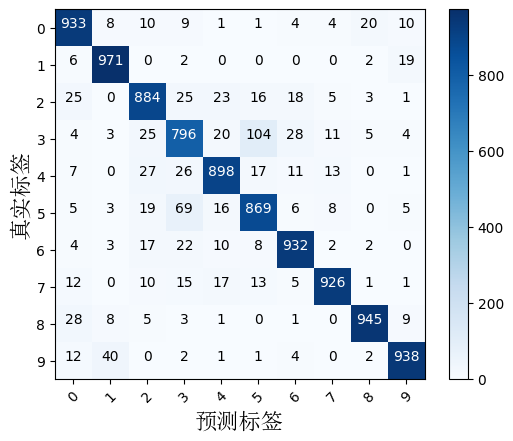

In [18]:
plot_lr_all_info(all_targets,all_preds,classes=list(range(10)), save_path=f"figs/confusion_matrix-qps-dadam_resnet18_{data_name}.png",use_CN=True)

In [19]:
# 记录日志
torch.save(aggregation.average_model().state_dict(), os.path.join(path,"final_model.pth"))
with open(os.path.join(path,"log.txt"), "w") as f:
    for epoch, (loss, acc) in enumerate(zip(train_losses, test_accuracies)):
        f.write(f"Epoch: {epoch}, Train Loss: {loss:.4f}, Test Acc: {acc:.4f}\n")

In [20]:
def smoothing(x ,smooth=0.99):
    """
    The smoothing function takes in a list of numbers and returns the same list with each number replaced by
    the average of itself and all previous numbers. The optional argument smooth is used to determine how much weight
    to give to the previous values, with 0 being no weight at all (i.e., just return the original array) and 1 giving
    equal weight to all values.

    :param x: Pass the data to be smoothed
    :param smooth: Control the amount of smoothing
    :return: A new array with the smoothed values
    :doc-author: Trelent
    """
    x = x.copy()
    weight = smooth
    for i in range(1 ,len(x)):
        x[i] = (x[ i -1] * weight + x[i]) / (weight + 1)
        weight = (weight + 1) * smooth
    return x


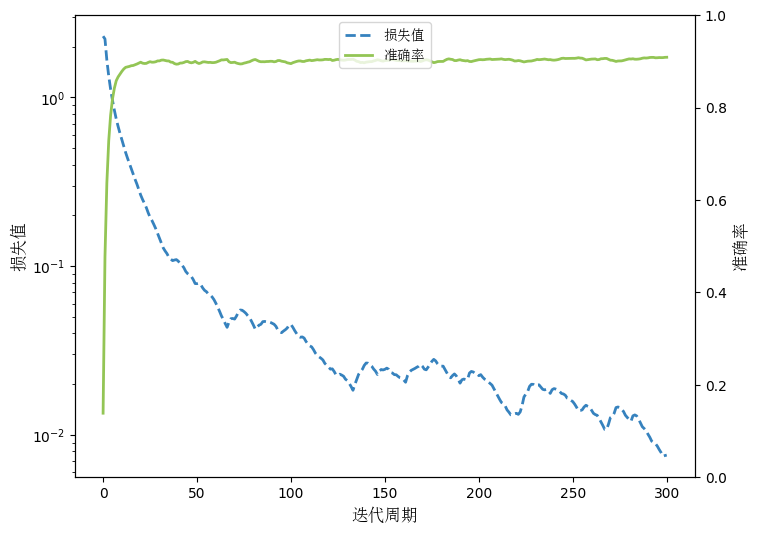

In [23]:
plt.figure(figsize=(8,6))

# 创建第一个Y轴（左侧）
ax1 = plt.gca()
ax1.plot(range(0, epoch_num+1), 
         smoothing(train_losses,smooth=0.9),
         linewidth=2,
           label="损失值", color='#3682be', linestyle='--')
ax1.set_xlabel("迭代周期", fontsize=12, fontproperties=chinese_font)
ax1.set_ylabel("损失值", fontsize=12, fontproperties=chinese_font)
ax1.set_yscale('log')
# ax1.tick_params(axis='y', labelcolor='#93c555')

# 创建第二个Y轴（右侧）
ax2 = ax1.twinx()
ax2.plot(range(0, epoch_num+1), 
         smoothing(test_accuracies,smooth=0.6),
         linewidth=2,
           label="准确率", color='#93c555', linestyle='-')
ax2.set_ylabel("准确率", fontsize=12, fontproperties=chinese_font)
ax2.set_ylim(0.0, 1.0) 
# ax2.tick_params(axis='y', labelcolor='#287DAB')

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=12, prop=chinese_font)

plt.savefig(f"figs/combined-q-dadam-ps-resnet18-{data_name}.png", dpi=600, bbox_inches='tight')
plt.show()

### 英文绘图

In [35]:
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # ✅ 宋体

              precision    recall  f1-score   support

           0  0.90057915 0.93300000 0.91650295      1000
           1  0.93725869 0.97100000 0.95383104      1000
           2  0.88665998 0.88400000 0.88532799      1000
           3  0.82146543 0.79600000 0.80853225      1000
           4  0.90982776 0.89800000 0.90387519      1000
           5  0.84450923 0.86900000 0.85657960      1000
           6  0.92368682 0.93200000 0.92782479      1000
           7  0.95562436 0.92600000 0.94057897      1000
           8  0.96428571 0.94500000 0.95454545      1000
           9  0.94939271 0.93800000 0.94366197      1000

    accuracy                      0.90920000     10000
   macro avg  0.90932898 0.90920000 0.90912602     10000
weighted avg  0.90932898 0.90920000 0.90912602     10000

Confusion matrix, without normalization
[[933   8  10   9   1   1   4   4  20  10]
 [  6 971   0   2   0   0   0   0   2  19]
 [ 25   0 884  25  23  16  18   5   3   1]
 [  4   3  25 796  20 104  28  11  

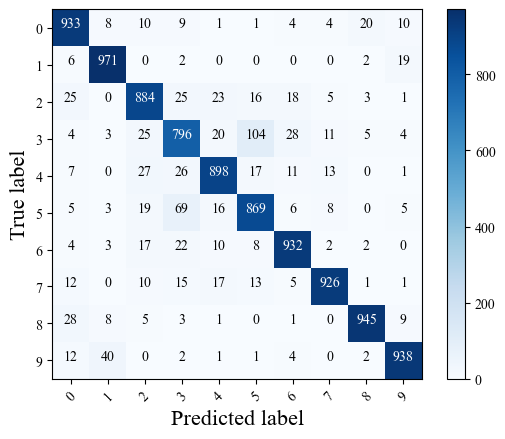

In [36]:
plot_lr_all_info(all_targets,all_preds,classes=list(range(10)), save_path=f"figs_en/confusion_matrix-qps-dadam_resnet18_{data_name}_en.pdf",use_CN=False)

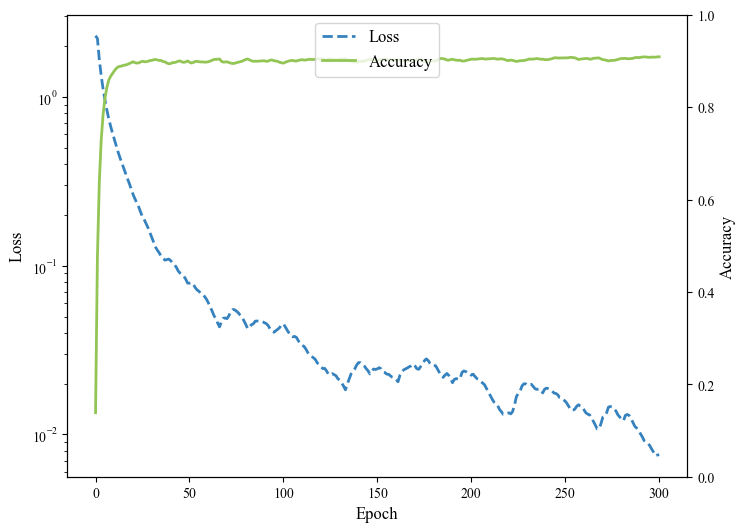

In [38]:
plt.figure(figsize=(8,6))

# 创建第一个Y轴（左侧）
ax1 = plt.gca()
ax1.plot(range(0, epoch_num+1), 
         smoothing(train_losses,smooth=0.9),
         linewidth=2,
           label="Loss", color='#3682be', linestyle='--')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_yscale('log')
# ax1.tick_params(axis='y', labelcolor='#93c555')

# 创建第二个Y轴（右侧）
ax2 = ax1.twinx()
ax2.plot(range(0, epoch_num+1), 
         smoothing(test_accuracies,smooth=0.6),
         linewidth=2,
           label="Accuracy", color='#93c555', linestyle='-')
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_ylim(0.0, 1.0) 
# ax2.tick_params(axis='y', labelcolor='#287DAB')

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=12)

plt.savefig(f"figs_en/combined-q-dadam-ps-resnet18-{data_name}_en.pdf", dpi=600, bbox_inches='tight')
plt.show()